
![Ironhack logo](https://i.imgur.com/1QgrNNw.png)

# Lab | Predicting Claim Amount with ML Linear Regression

## Introduction

For this lab, we still keep using the [marketing_customer_analysis.csv file](marketing_customer_analysis.csv) - the US car insurance data set. You should be able to pick up where you left off in the previous rounds of customer behaviour analysis. However this time we will look to apply a linear regression machine learning model 

Review the previous rounds and follow the steps as shown in previous lectures.


### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
#import the model
from sklearn import linear_model
#import evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
def clean_headers(a):
    """
    Input is a dataset, it will put the column labels as lower case, strip the names and subsitute spaces with dashes
    """
    cols=[]
    for i in range(len(a.columns)):
        cols.append(a.columns[i].lower().strip().replace(" ","_"))
        
    a.columns = cols


## 01 - Problem (case study)
Familiarise yourself with Data Descriptions and the Goal.


### data definitions for handy reference :

Unnamed: Index  
customer: Customer ID  
state: US State  
customer_lifetime_value: CLV is the client economic value for a company during all their relationship  
response: Response to marketing calls (customer engagement)  
coverage: Customer coverage type  
education: Customer education level  
effective_to_date: Effective to date  
employmentstatus: Customer employment status  
gender: Customer gender  
income: Customer income  
location_code: Customer living zone  
marital_status: Customer marital status  
monthly_premium_auto: Monthly premium  
months_since_last_claim: Last customer claim  
months_since_policy_inception: Policy Inception  
number_of_open_complaints: Open claims  
number_of_policies: Number policies  
policy_type: Policy type  
policy: Policy  
renew_offer_type: Renew  
sales_channel: Sales channel (customer-company first contact)  
total_claim_amount: Claims amount  
vehicle_class: Vehicle class  
vehicle_size: Vehicle size  
vehicle_type: Vehicle type  

## 02 - Getting Data
Read the .csv file into python

In [4]:
data = pd.read_csv('marketing_customer_analysis.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## 03 - Cleaning/Wrangling/EDA
Change headers names.
Deal with NaN values, replace with appropriate method. 

split categorical Features and Numerical Features.

Explore visually both sets of features, to identify next steps.

Look at potential multicollinearity using a correlation matrix or other approach. 


In [6]:
#Earlier we saw no NaN Values, so we keep going with cleaning

In [7]:
#Cleaning header names
clean_headers(data)


In [8]:
#Separating by categories
y = data['total_claim_amount']
X_num = data.select_dtypes(include = np.number)
X_num = X_num.drop(columns = ['total_claim_amount'])
X_cat = data.select_dtypes(include = np.object)


<ipython-input-8-5722f7ffd1bb>:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_cat = data.select_dtypes(include = np.object)


In [9]:
#We start by exploring numerical values first

X_num.head()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,2763.519279,56274,69,32,5,0,1
1,6979.535903,0,94,13,42,0,8
2,12887.431650,48767,108,18,38,0,2
3,7645.861827,0,106,18,65,0,7
4,2813.692575,43836,73,12,44,0,1


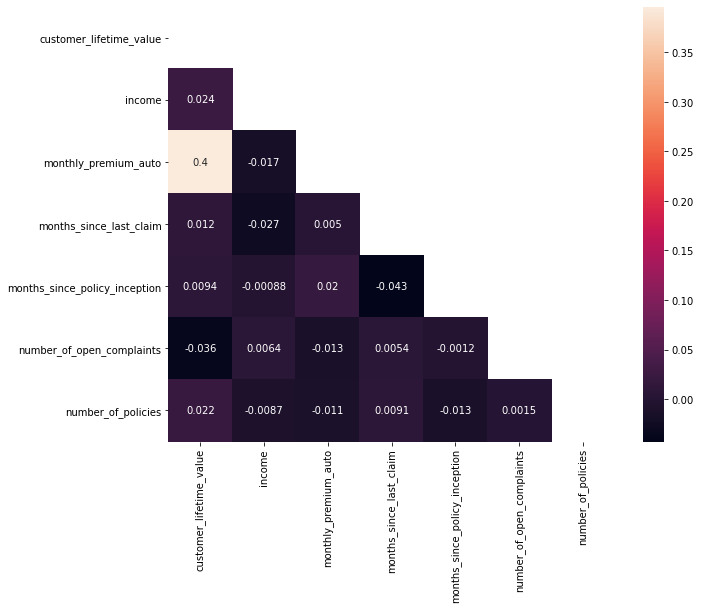

In [10]:
# Correlation heatmap to check for multicollinearity

correlations_matrix = X_num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [11]:
#No high correlation, so we'll keep all columns.


## 04 - Pre-Processing Data
Dealing with outliers.
Normalization - ie use chosen scaler to transform selected columns into normal distribution as needed for linear regression model. Propose: MinMax scaler on 'effective_to_date' and standard scaler on numerical columns.

Encoding Categorical Data fields using OHE.

Bring categorical and numerical columns back together using pd.concat.

Define X and y, the y value you are seeking to predict is claim amount.

Splitting into train set and test dataset using random state, eg 80%:20% .

In [12]:
# Dealing with "effective_to_date". Have to turn it into a datetime object first, then use minmax_scale to apply to 1 column only.
data['effective_to_date'] = pd.to_datetime(data['effective_to_date'])

from sklearn.preprocessing import minmax_scale 
dates = minmax_scale(data['effective_to_date'])
dates = dates.reshape(-1,1)

In [13]:
#Now the rest of numerical columns, we standardize their distribution:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X_num)
x_standardized = transformer.transform(X_num)

In [14]:
#With the categorical, we will drop 'customer' as its and index for customers and tells nothing about the data, and dates
#because we processed them earlier already
X_cat_cl = X_cat.drop(['customer','effective_to_date'],axis = 1)

In [15]:
#Now categorical data. We will use OneHotEncoder to codify the data
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(X_cat_cl)
encoded = encoder.transform(X_cat_cl).toarray()

In [16]:
#Now we see if all of our X have the same size
print(dates.shape)
print(x_standardized.shape)
print(encoded.shape)

(9134, 1)
(9134, 7)
(9134, 43)


In [17]:
#And we put them together
X = np.concatenate((x_standardized, encoded, dates), axis=1)
X.shape

(9134, 51)

In [18]:
#Does it match y?
y.shape

(9134,)

In [19]:
#step 7 split the data into train and test randomly, as a %
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=100)

In [21]:
#step 8 apply the machine learn model for It3 
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
predictions  = lm.predict(X_test)

#And print the scores
r2 = r2_score(y_test, predictions)
print( "r2 Score:   "+ str(r2))

mse = mean_squared_error(y_test, predictions)
print("MSE Score:  "+ str(mse))

import math 
rmse = math.sqrt(mse)
print("RMSE Score: "+ str(rmse))

n = len(X_test) 
p = X_test.shape[1]
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
print("Adj. r2:    "+str(adj_r2))

r2 Score:   0.769503022309202
MSE Score:  18313.654663361463
RMSE Score: 135.327952261761
Adj. r2:    0.7662394615478941


### Not good enough, let's try some more stuff.

In [22]:
#We first define a function to clean outliers 
def clean_outliers(data,col):
    """
    Will input the column name as data['Column'], will return the modified dataframe
    """
    iqr = np.percentile(data[col],75) - np.percentile(data[col],25)
    upper_limit = np.percentile(data[col],75) + 1.5*iqr
    lower_limit = np.percentile(data[col],25) - 1.5*iqr

    return data[(data[col]>lower_limit) & (data[col]<upper_limit)]


In [23]:
#And another one that rescales a column to a log scale  
def log_rescaler(data,col):
    """
    Will convert the scale of the numerical column to a log scale, and fill infinite values with the mean
    """
    def log_transfom_clean_(x):
        x = np.log(x)
        if np.isfinite(x):
            return x
        else:
            return np.NAN #  we can replace NANs with mean values in the next step   
        
    data[col] = list(map(log_transfom_clean_, data[col]))

    return data[col].fillna(np.mean(data[col]))

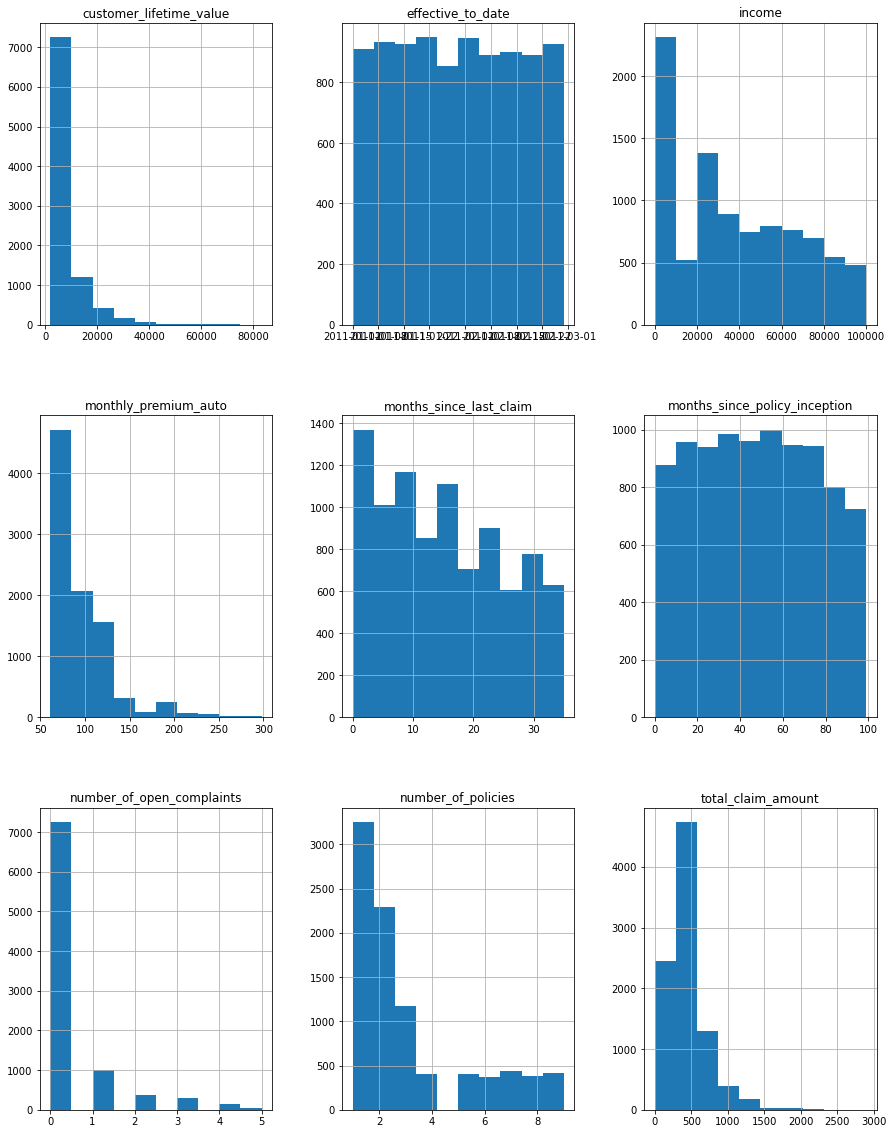

In [24]:
#We create a new dframe, to keep the original untouched
data2 = data
#Visualizing the numeric variables 
data2.hist(figsize = (15,20));


In [25]:
#let's take outliers out from monthly_premium_auto, customer_lifetime_value and income:

<AxesSubplot:xlabel='customer_lifetime_value'>

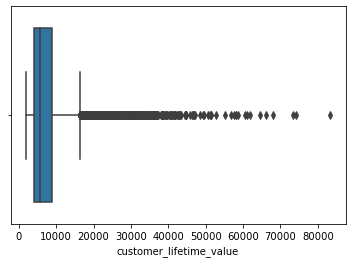

In [26]:
sns.boxplot(x=data2['customer_lifetime_value'])

(8317, 24)


<AxesSubplot:xlabel='customer_lifetime_value'>

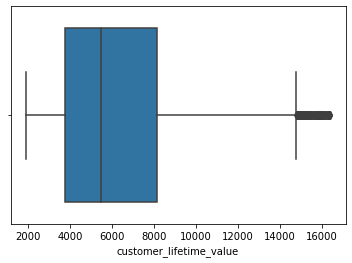

In [27]:
#clean outliers, and visualize again 

data2 = clean_outliers(data2,'customer_lifetime_value')
print(data2.shape)
sns.boxplot(x=data2['customer_lifetime_value'])

(8016, 24)


<AxesSubplot:xlabel='monthly_premium_auto'>

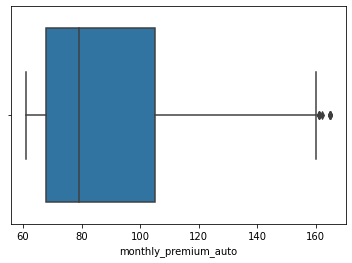

In [28]:
# looks better, now with monthly_premium_auto, and customer_lifetime_value
data2 = clean_outliers(data2,'monthly_premium_auto')
print(data2.shape)
sns.boxplot(x=data2['monthly_premium_auto'])

(8016, 24)


<AxesSubplot:xlabel='income'>

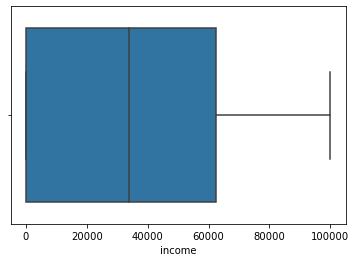

In [29]:
data2 = clean_outliers(data2,'income')
print(data2.shape)
sns.boxplot(x=data2['income'])


In [30]:
#Separating by categories
y = data2['total_claim_amount']
X_num = data2.select_dtypes(include = np.number)
X_num = X_num.drop(columns = ['total_claim_amount'])
X_cat = data2.select_dtypes(include = np.object)


<ipython-input-30-8d23ba28ea55>:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_cat = data2.select_dtypes(include = np.object)


C:\Users\asomm\anaconda3\envs\excondables\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customer_lifetime_value', ylabel='Density'>

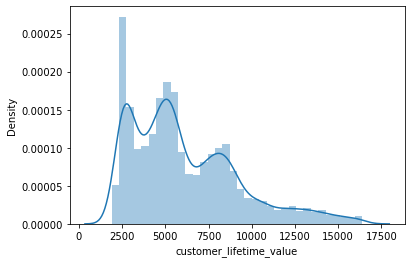

In [31]:
#Now the we want to standardize distributions
sns.distplot(X_num['customer_lifetime_value'])

In [32]:
#Using our log_rescaler function we proceed
X_num['customer_lifetime_value'] = log_rescaler(X_num,'customer_lifetime_value')

C:\Users\asomm\anaconda3\envs\excondables\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customer_lifetime_value', ylabel='Density'>

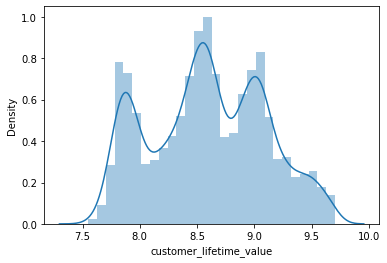

In [33]:
sns.distplot(X_num['customer_lifetime_value'])

C:\Users\asomm\anaconda3\envs\excondables\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monthly_premium_auto', ylabel='Density'>

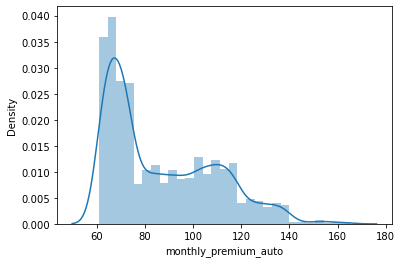

In [34]:
sns.distplot(X_num['monthly_premium_auto'])

C:\Users\asomm\anaconda3\envs\excondables\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monthly_premium_auto', ylabel='Density'>

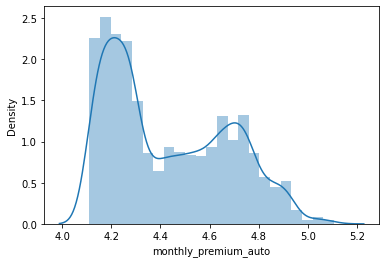

In [35]:
X_num['monthly_premium_auto'] = log_rescaler(X_num,'monthly_premium_auto')
sns.distplot(X_num['monthly_premium_auto'])

C:\Users\asomm\anaconda3\envs\excondables\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

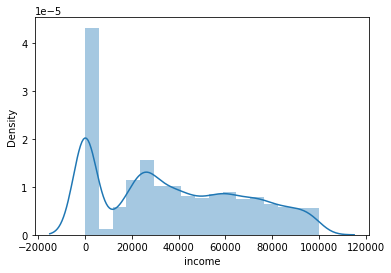

In [36]:
sns.distplot(X_num['income'])
#we dont want to rescale this one as zero income is very significative, and we would lost this information (?)

In [37]:
X_num.shape

(8016, 7)

In [38]:
x_standardized = X_num

In [39]:
#Transforming dates to numerical values
from sklearn.preprocessing import minmax_scale 
dates = minmax_scale(data2['effective_to_date'])
dates = dates.reshape(-1,1)


#dropping customer and date, as they are processed already
X_cat_cl = X_cat.drop(['customer'],axis = 1)


#Encoding categoricals with OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(X_cat_cl)
encoded = encoder.transform(X_cat_cl).toarray()

#Now we see if all of our X have the same size
print(dates.shape)
print(x_standardized.shape)
print(encoded.shape)


(8016, 1)
(8016, 7)
(8016, 41)


In [40]:
#And we put them together, we compare it with y
X = np.concatenate((x_standardized, encoded, dates), axis=1)
print(X.shape)
print(y.shape)

(8016, 49)
(8016,)


In [41]:
#step 7 split the data into train and test randomly, as a %
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=120)


#step 8 apply the machine learn model for It3 
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
predictions  = lm.predict(X_test)

#And print the scores
r2 = r2_score(y_test, predictions)
print( "r2 Score:   "+ str(r2))

mse = mean_squared_error(y_test, predictions)
print("MSE Score:  "+ str(mse))

import math 
rmse = math.sqrt(mse)
print("RMSE Score: "+ str(rmse))

n = len(X_test) 
p = X_test.shape[1]
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
print("Adj. r2:    "+str(adj_r2))

r2 Score:   0.7372789560823247
MSE Score:  14200.057614528692
RMSE Score: 119.16399462307686
Adj. r2:    0.7332012458663076


## 07 - Reporting
Present results inside your notebook with appropriate annotation describing the accuracy of the model and business insight gained.


In [42]:
#After manually cleaning outliers and scaling the numerical values, the R2 score decreased a bit,
#but our mean square error has been reduced, giving i believe a more accurate prediction.  